In [1]:
import gc
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, RegressorMixin

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cpu


In [2]:
DATA_PATH = Path("cup25_train_clean.csv")  # edit path if needed
df = pd.read_csv(DATA_PATH)

X = df[[f"x{i}" for i in range(1, 13)]].to_numpy()
y = df[[f"y{i}" for i in range(1, 5)]].to_numpy()

X_dev, X_int, y_dev, y_int = train_test_split(
    X, y, test_size=0.2, random_state=SEED, shuffle=True
)

print("X_dev:", X_dev.shape, "X_int:", X_int.shape)

X_dev: (400, 12) X_int: (100, 12)


In [3]:
def mee(y_true, y_pred):
    return float(np.mean(np.linalg.norm(y_true - y_pred, axis=1)))

mee_scorer = make_scorer(mee, greater_is_better=False)  # GridSearch will maximize => negative MEE


In [4]:
X_dev, X_int, y_dev, y_int = train_test_split(
    X, y, test_size=0.2, random_state=SEED, shuffle=True
)
print("X_dev:", X_dev.shape, "X_int:", X_int.shape)

X_dev: (400, 12) X_int: (100, 12)


In [5]:
class TorchMLP(nn.Module):
    def __init__(self, n_in, hidden_layer_sizes=(32,), n_out=4, activation="relu"):
        super().__init__()
        act = nn.ReLU if activation == "relu" else nn.Tanh
        layers = []
        prev = n_in
        for h in hidden_layer_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(act())
            prev = h
        layers.append(nn.Linear(prev, n_out))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class TorchMLPRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        hidden_layer_sizes=(32,),
        activation="relu",
        batch_size=64,
        lr=0.01,
        momentum=0.9,
        nesterov=True,
        weight_decay=1e-3,
        max_epochs=100,
        random_state=42,
        device=None,
        verbose=0,
    ):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.batch_size = batch_size
        self.lr = lr
        self.momentum = momentum
        self.nesterov = nesterov
        self.weight_decay = weight_decay
        self.max_epochs = max_epochs
        self.random_state = random_state
        self.device = device
        self.verbose = verbose

        self.model_ = None
        self.device_ = None

    def _get_device(self):
        if self.device is None:
            return torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if self.device == "cuda" and (not torch.cuda.is_available()):
            return torch.device("cpu")
        return torch.device(self.device)

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32)

        np.random.seed(self.random_state)
        torch.manual_seed(self.random_state)

        device = self._get_device()
        self.device_ = device

        n_in = X.shape[1]
        n_out = y.shape[1]

        X_t = torch.from_numpy(X).to(device)
        y_t = torch.from_numpy(y).to(device)

        loader = DataLoader(
            TensorDataset(X_t, y_t),
            batch_size=self.batch_size,
            shuffle=True
        )

        model = TorchMLP(
            n_in=n_in,
            hidden_layer_sizes=self.hidden_layer_sizes,
            n_out=n_out,
            activation=self.activation
        ).to(device)

        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=self.lr,
            momentum=self.momentum,
            nesterov=self.nesterov,
            weight_decay=self.weight_decay
        )

        for ep in range(self.max_epochs):
            model.train()
            for xb, yb in loader:
                optimizer.zero_grad(set_to_none=True)
                pred = model(xb)
                loss = criterion(pred, yb)
                loss.backward()
                optimizer.step()

        self.model_ = model

        # reduce GPU memory fragmentation across many CV fits
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        X_t = torch.from_numpy(X).to(self.device_)
        self.model_.eval()
        with torch.no_grad():
            pred = self.model_(X_t).detach().cpu().numpy()
        return pred


In [6]:
# X pipeline
x_pipe = Pipeline([
    ("x_scaler", StandardScaler()),
    ("pca", PCA(n_components=4, random_state=SEED)),
    ("mlp", TorchMLPRegressor(device=str(DEVICE), random_state=SEED))
])

# Scale y per fold (anti-leakage)
estimator = TransformedTargetRegressor(
    regressor=x_pipe,
    transformer=StandardScaler()
)


In [7]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def mee(y_true, y_pred):
    return float(np.mean(np.linalg.norm(y_true - y_pred, axis=1)))


class TorchMLP(nn.Module):
    def __init__(self, n_in, hidden_layer_sizes=(32,), n_out=4, activation="relu"):
        super().__init__()
        act = nn.ReLU if activation == "relu" else nn.Tanh
        layers = []
        prev = n_in
        for h in hidden_layer_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(act())
            prev = h
        layers.append(nn.Linear(prev, n_out))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


@torch.no_grad()
def _predict_numpy_batched(model, X_np, device, batch_size=2048):
    """Fast batched prediction to reduce overhead."""
    model.eval()
    X_np = np.asarray(X_np, dtype=np.float32)
    preds = []
    for i in range(0, X_np.shape[0], batch_size):
        xb = torch.from_numpy(X_np[i:i+batch_size]).to(device)
        preds.append(model(xb).detach().cpu().numpy())
    return np.vstack(preds)


def torch_mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    best_params,            # pass gs.best_params_ here
    epochs=500,
    cv=None,
    random_state=42,
    pca_components=4,
    device=None,
    pred_batch_size=4096,
    use_step_lr=False,      # optional stability tweak (off by default)
    step_lr_step_size=50,
    step_lr_gamma=0.9,
):
    """
    Returns:
      train_mean: (epochs,)
      val_mean  : (epochs,)

    Anti-leakage:
      - Fit X scaler/PCA and y scaler on train-fold only.
      - Transform validation fold using train-fold preprocessors.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    # ---- Helper: fetch params regardless of prefix style ----
    def getp(key_no_prefix, default=None):
        # accepts either "regressor__mlp__lr" or "lr", etc.
        if f"regressor__mlp__{key_no_prefix}" in best_params:
            return best_params[f"regressor__mlp__{key_no_prefix}"]
        if key_no_prefix in best_params:
            return best_params[key_no_prefix]
        return default

    hidden_layer_sizes = getp("hidden_layer_sizes", (32,))
    activation         = getp("activation", "relu")
    batch_size         = int(getp("batch_size", 64))
    lr                 = float(getp("lr", 0.01))
    momentum           = float(getp("momentum", 0.9))
    nesterov           = bool(getp("nesterov", True))
    weight_decay       = float(getp("weight_decay", 1e-3))

    if cv is None:
        from sklearn.model_selection import KFold
        cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    fold_train_curves = []
    fold_val_curves = []

    for fold_i, (tr_idx, va_idx) in enumerate(cv.split(X_dev)):
        # fold seeds for reproducibility
        np.random.seed(random_state + fold_i)
        torch.manual_seed(random_state + fold_i)

        X_tr, X_va = X_dev[tr_idx], X_dev[va_idx]
        y_tr, y_va = y_dev[tr_idx], y_dev[va_idx]

        # ---- Preprocess (fit on train-fold only) ----
        x_scaler = StandardScaler().fit(X_tr)
        X_tr_s = x_scaler.transform(X_tr)
        X_va_s = x_scaler.transform(X_va)

        pca = PCA(n_components=pca_components, random_state=random_state).fit(X_tr_s)
        X_tr_p = pca.transform(X_tr_s).astype(np.float32)
        X_va_p = pca.transform(X_va_s).astype(np.float32)

        y_scaler = StandardScaler().fit(y_tr)
        y_tr_s = y_scaler.transform(y_tr).astype(np.float32)

        # ---- Build model ----
        model = TorchMLP(
            n_in=X_tr_p.shape[1],
            hidden_layer_sizes=hidden_layer_sizes,
            n_out=y_tr.shape[1],
            activation=activation
        ).to(device)

        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=lr,
            momentum=momentum,
            nesterov=nesterov,
            weight_decay=weight_decay
        )
        criterion = nn.MSELoss()

        scheduler = None
        if use_step_lr:
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=step_lr_step_size, gamma=step_lr_gamma
            )

        train_loader = DataLoader(
            TensorDataset(
                torch.from_numpy(X_tr_p).to(device),
                torch.from_numpy(y_tr_s).to(device)
            ),
            batch_size=batch_size,
            shuffle=True
        )

        train_curve = np.zeros(epochs, dtype=float)
        val_curve   = np.zeros(epochs, dtype=float)

        # ---- Train + log per epoch ----
        for ep in range(epochs):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad(set_to_none=True)
                pred = model(xb)
                loss = criterion(pred, yb)
                loss.backward()
                optimizer.step()

            if scheduler is not None:
                scheduler.step()

            # Predict on train/val, then inverse-transform y
            pred_tr_s = _predict_numpy_batched(model, X_tr_p, device, batch_size=pred_batch_size)
            pred_va_s = _predict_numpy_batched(model, X_va_p, device, batch_size=pred_batch_size)

            pred_tr = y_scaler.inverse_transform(pred_tr_s)
            pred_va = y_scaler.inverse_transform(pred_va_s)

            train_curve[ep] = mee(y_tr, pred_tr)
            val_curve[ep]   = mee(y_va, pred_va)

        fold_train_curves.append(train_curve)
        fold_val_curves.append(val_curve)

        # cleanup to reduce GPU fragmentation during long runs
        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    train_mean = np.mean(np.stack(fold_train_curves, axis=0), axis=0)
    val_mean   = np.mean(np.stack(fold_val_curves, axis=0), axis=0)
    return train_mean, val_mean


# Grid search phase 1

In [6]:
cv5 = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_splits = list(cv5.split(X_dev))  # fixed splits

param_grid = {
    "regressor__mlp__hidden_layer_sizes": [(8,), (12,), (16,), (32,)],
    "regressor__mlp__activation": ["relu", "tanh"],     
    "regressor__mlp__batch_size": [32, 64, 128],
    "regressor__mlp__lr": [0.005, 0.01, 0.02],         
    "regressor__mlp__momentum": [0.7, 0.9],
    "regressor__mlp__nesterov": [True],
    "regressor__mlp__weight_decay": [1e-4, 1e-3, 1e-2],
    "regressor__mlp__max_epochs": [200],            
}

gs = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=mee_scorer,
    cv=cv_splits,
    n_jobs=1,                 # IMPORTANT for torch on GPU
    refit=True,               # refit best on full X_dev/y_dev
    return_train_score=True,
    error_score=np.nan,
    verbose=2
)

gs.fit(X_dev, y_dev)

print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=32, regressor__mlp__hidden_layer_sizes=(8,), regressor__mlp__lr=0.005, regressor__mlp__max_epochs=200, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.0001; total time=  16.5s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=32, regressor__mlp__hidden_layer_sizes=(8,), regressor__mlp__lr=0.005, regressor__mlp__max_epochs=200, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.0001; total time=   4.9s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=32, regressor__mlp__hidden_layer_sizes=(8,), regressor__mlp__lr=0.005, regressor__mlp__max_epochs=200, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.0001; total time=   4.6s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=

In [7]:
best_model = gs.best_estimator_
y_int_pred = best_model.predict(X_int)
print("Internal 20% MEE:", mee(y_int, y_int_pred))

Internal 20% MEE: 21.735400669939164


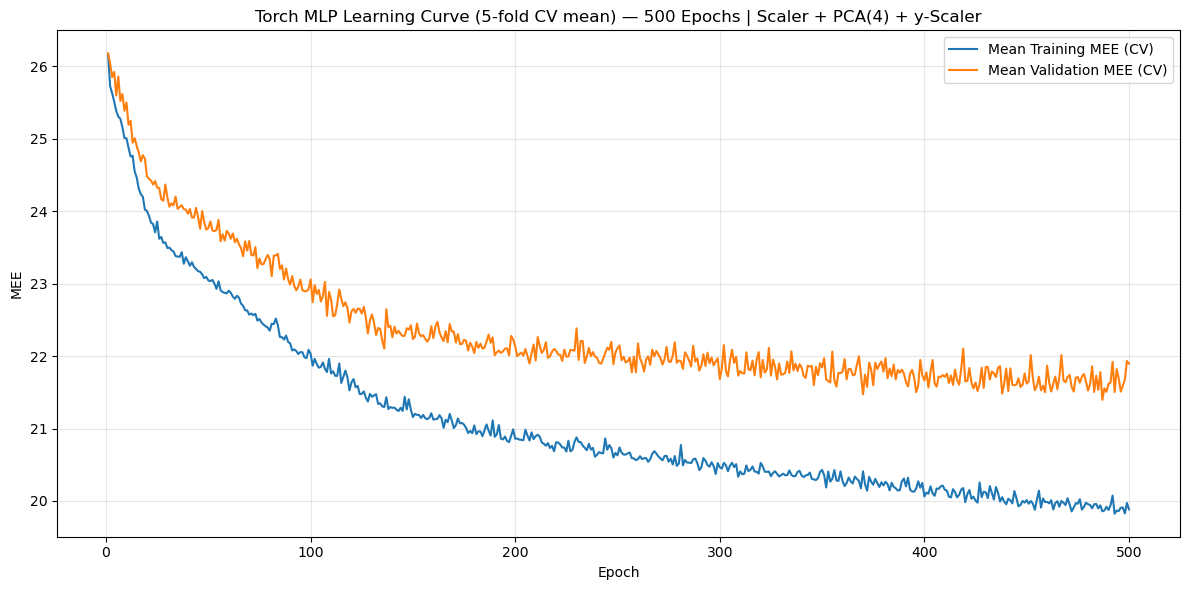

In [9]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)

MLP_BEST = gs.best_params_  # <-- directly from GridSearchCV

train_mean, val_mean = torch_mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    best_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4,
    device=None,         # auto cuda/cpu
    use_step_lr=False,   # set True if you want smoother curves
)

epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("Torch MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

# Grid search 2: add 2 layers model; increase batch size to get smooth curve 

In [9]:
cv5 = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_splits = list(cv5.split(X_dev))  # fixed splits

param_grid = {
    "regressor__mlp__hidden_layer_sizes": [(8,), (16,), (32,), (32,16)],
    "regressor__mlp__activation": ["relu", "tanh"],    
    "regressor__mlp__batch_size": [64, 128],
    "regressor__mlp__lr": [0.005, 0.001, 0.01],        
    "regressor__mlp__momentum": [0.7, 0.9],
    "regressor__mlp__nesterov": [True],
    "regressor__mlp__weight_decay": [1e-2, 0.1],
    "regressor__mlp__max_epochs": [100],           
}

gs = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=mee_scorer,
    cv=cv_splits,
    n_jobs=1,                 # IMPORTANT for torch on GPU
    refit=True,               # refit best on full X_dev/y_dev
    return_train_score=True,
    error_score=np.nan,
    verbose=2
)

gs.fit(X_dev, y_dev)

print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=64, regressor__mlp__hidden_layer_sizes=(8,), regressor__mlp__lr=0.005, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=  36.5s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=64, regressor__mlp__hidden_layer_sizes=(8,), regressor__mlp__lr=0.005, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=  33.6s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=64, regressor__mlp__hidden_layer_sizes=(8,), regressor__mlp__lr=0.005, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=  25.7s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=64, reg

In [10]:
best_model = gs.best_estimator_
y_int_pred = best_model.predict(X_int)
print("Internal 20% MEE:", mee(y_int, y_int_pred))

Internal 20% MEE: 23.947744120152667


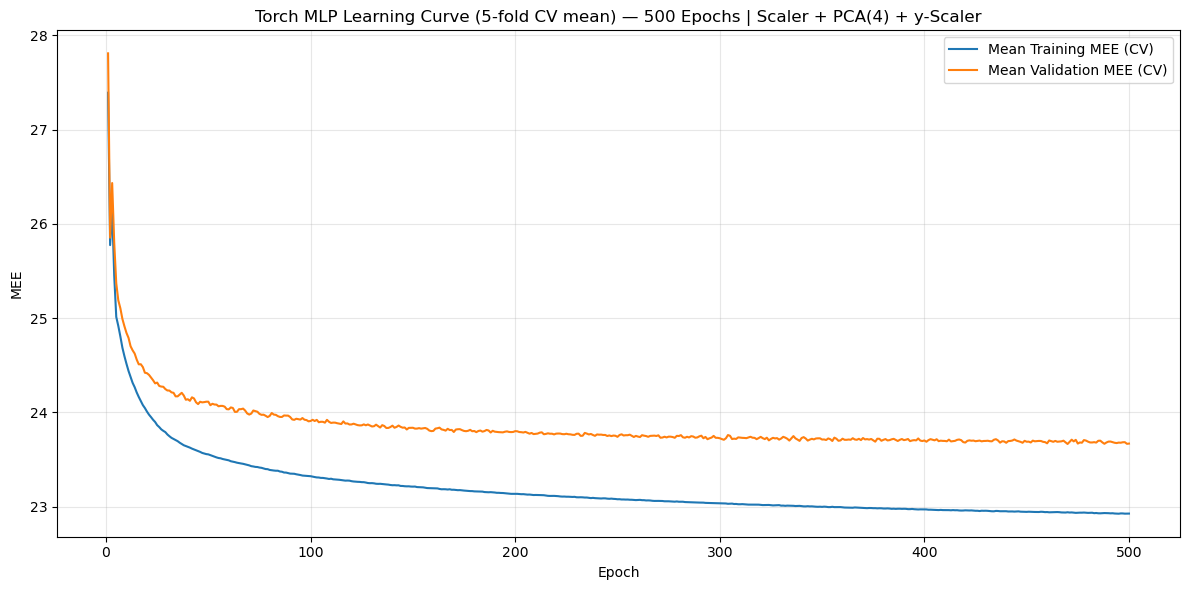

In [11]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)

MLP_BEST = gs.best_params_  # <-- directly from GridSearchCV

train_mean, val_mean = torch_mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    best_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4,
    device=None,         # auto cuda/cpu
    use_step_lr=False,   # set True if you want smoother curves
)

epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("Torch MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

## phase 3: increase batch size to get smooth curve

In [12]:
cv5 = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_splits = list(cv5.split(X_dev))  # fixed splits

param_grid = {
    "regressor__mlp__hidden_layer_sizes": [(8,), (16,), (32,), (32,16)],
    "regressor__mlp__activation": ["relu", "tanh"],    
    "regressor__mlp__batch_size": [256, 128],
    "regressor__mlp__lr": [0.005, 0.01],        
    "regressor__mlp__momentum": [0.7, 0.9],
    "regressor__mlp__nesterov": [True],
    "regressor__mlp__weight_decay": [1e-2, 0.1],
    "regressor__mlp__max_epochs": [100],           
}

gs = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=mee_scorer,
    cv=cv_splits,
    n_jobs=1,                 # IMPORTANT for torch on GPU
    refit=True,               # refit best on full X_dev/y_dev
    return_train_score=True,
    error_score=np.nan,
    verbose=2
)

gs.fit(X_dev, y_dev)

print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)


Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=256, regressor__mlp__hidden_layer_sizes=(8,), regressor__mlp__lr=0.005, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.1s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=256, regressor__mlp__hidden_layer_sizes=(8,), regressor__mlp__lr=0.005, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.2s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=256, regressor__mlp__hidden_layer_sizes=(8,), regressor__mlp__lr=0.005, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.2s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=256,

Early-stop selected best_epoch = 209 | best_val_MEE = 23.824420
Early-stop would stop at epoch = 239 (patience reached)


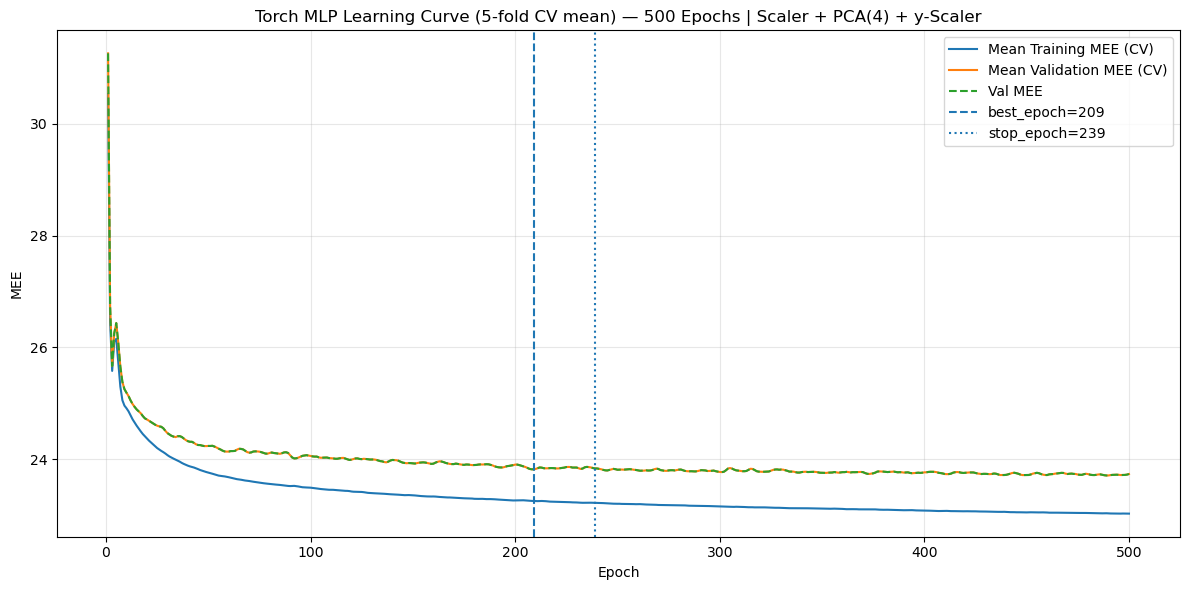

In [14]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)
MLP_BEST = gs.best_params_

train_mean, val_mean = torch_mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    best_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4,
    device=None,
    use_step_lr=False,
)

# -------------------------
# EARLY STOPPING (post-hoc) on mean val curve
# -------------------------
def early_stop_epoch(val_curve, patience=30, min_delta=1e-4, smooth_window=1):
    v = np.asarray(val_curve, dtype=float)

    # optional smoothing to make the stop decision less noisy
    if smooth_window and smooth_window > 1:
        k = np.ones(smooth_window) / smooth_window
        v_s = np.convolve(v, k, mode="same")
    else:
        v_s = v

    best_val = np.inf
    best_ep0 = 0
    wait = 0
    stop_ep0 = len(v_s) - 1

    for ep0, val in enumerate(v_s):
        if val < best_val - min_delta:
            best_val = val
            best_ep0 = ep0
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                stop_ep0 = ep0
                break

    # return 1-based epochs
    return best_ep0 + 1, stop_ep0 + 1, v[best_ep0], v_s

best_epoch, stop_epoch, best_val, val_smooth = early_stop_epoch(
    val_mean,
    patience=30,
    min_delta=1e-4,
    smooth_window=1,   
)

print(f"Early-stop selected best_epoch = {best_epoch} | best_val_MEE = {best_val:.6f}")
print(f"Early-stop would stop at epoch = {stop_epoch} (patience reached)")

# -------------------------
# PLOT
# -------------------------
epochs = np.arange(1, len(train_mean) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")

# optional: plot smoothed val
plt.plot(epochs, val_smooth, linestyle="--", label="Val MEE")

# mark best epoch and stop epoch
plt.axvline(best_epoch, linestyle="--", label=f"best_epoch={best_epoch}")
plt.axvline(stop_epoch, linestyle=":",  label=f"stop_epoch={stop_epoch}")

plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("Torch MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

In [16]:
from sklearn.base import clone

best_epoch_to_use = best_epoch 

best_model_es = clone(gs.best_estimator_)
best_model_es.set_params(regressor__mlp__max_epochs=best_epoch_to_use)
best_model_es.fit(X_dev, y_dev)

y_int_pred = best_model_es.predict(X_int)
print("Internal 20% MEE (refit @best_epoch):", mee(y_int, y_int_pred))

Internal 20% MEE (refit @best_epoch): 23.91782878977113


# phase 4: best model of 1 layer with many 2 layers model

In [17]:
cv5 = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_splits = list(cv5.split(X_dev))  # fixed splits

param_grid = {
    "regressor__mlp__hidden_layer_sizes": [(8, 4), (16, 16), (32,), (32,16)],
    "regressor__mlp__activation": ["relu", "tanh"],    
    "regressor__mlp__batch_size": [256, 128],
    "regressor__mlp__lr": [0.005, 0.01],        
    "regressor__mlp__momentum": [0.7, 0.9],
    "regressor__mlp__nesterov": [True],
    "regressor__mlp__weight_decay": [1e-2, 0.1],
    "regressor__mlp__max_epochs": [100],           
}

gs = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=mee_scorer,
    cv=cv_splits,
    n_jobs=1,                 # IMPORTANT for torch on GPU
    refit=True,               # refit best on full X_dev/y_dev
    return_train_score=True,
    error_score=np.nan,
    verbose=2
)

gs.fit(X_dev, y_dev)

print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)


Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=256, regressor__mlp__hidden_layer_sizes=(8, 4), regressor__mlp__lr=0.005, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.4s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=256, regressor__mlp__hidden_layer_sizes=(8, 4), regressor__mlp__lr=0.005, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.4s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=256, regressor__mlp__hidden_layer_sizes=(8, 4), regressor__mlp__lr=0.005, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.8s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_siz

Early-stop selected best_epoch = 209 | best_val_MEE = 23.824420
Early-stop would stop at epoch = 239 (patience reached)


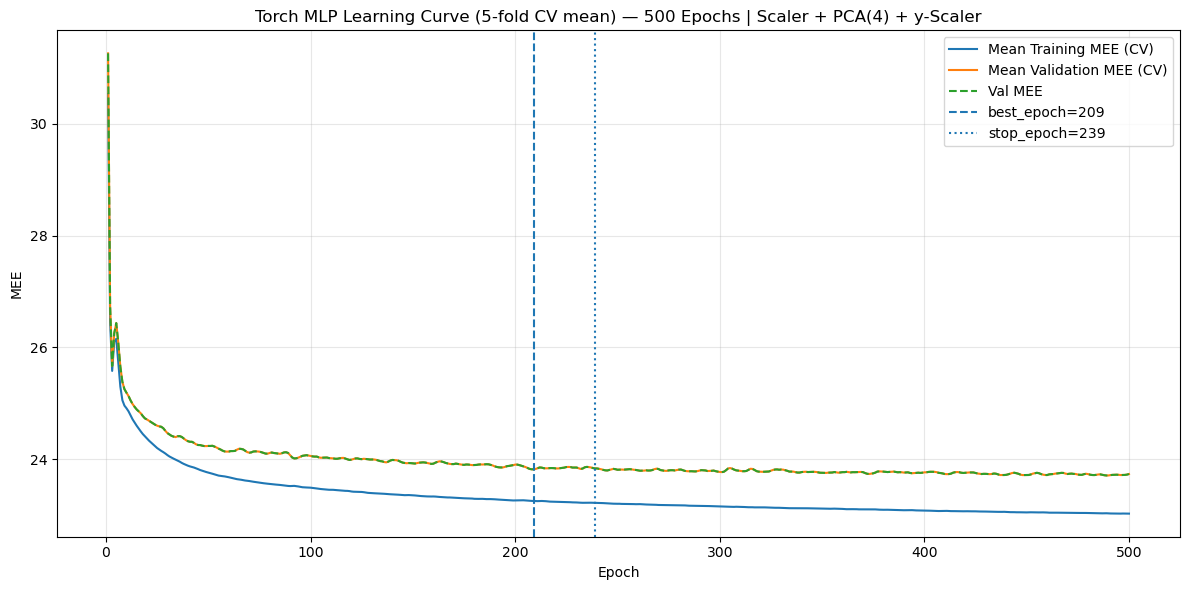

In [18]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)
MLP_BEST = gs.best_params_

train_mean, val_mean = torch_mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    best_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4,
    device=None,
    use_step_lr=False,
)

# -------------------------
# EARLY STOPPING (post-hoc) on mean val curve
# -------------------------
def early_stop_epoch(val_curve, patience=30, min_delta=1e-4, smooth_window=1):
    v = np.asarray(val_curve, dtype=float)

    # optional smoothing to make the stop decision less noisy
    if smooth_window and smooth_window > 1:
        k = np.ones(smooth_window) / smooth_window
        v_s = np.convolve(v, k, mode="same")
    else:
        v_s = v

    best_val = np.inf
    best_ep0 = 0
    wait = 0
    stop_ep0 = len(v_s) - 1

    for ep0, val in enumerate(v_s):
        if val < best_val - min_delta:
            best_val = val
            best_ep0 = ep0
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                stop_ep0 = ep0
                break

    # return 1-based epochs
    return best_ep0 + 1, stop_ep0 + 1, v[best_ep0], v_s

best_epoch, stop_epoch, best_val, val_smooth = early_stop_epoch(
    val_mean,
    patience=30,
    min_delta=1e-4,
    smooth_window=1,   
)

print(f"Early-stop selected best_epoch = {best_epoch} | best_val_MEE = {best_val:.6f}")
print(f"Early-stop would stop at epoch = {stop_epoch} (patience reached)")

# -------------------------
# PLOT
# -------------------------
epochs = np.arange(1, len(train_mean) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")

# optional: plot smoothed val
plt.plot(epochs, val_smooth, linestyle="--", label="Val MEE")

# mark best epoch and stop epoch
plt.axvline(best_epoch, linestyle="--", label=f"best_epoch={best_epoch}")
plt.axvline(stop_epoch, linestyle=":",  label=f"stop_epoch={stop_epoch}")

plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("Torch MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

In [19]:
from sklearn.base import clone

best_epoch_to_use = best_epoch  

best_model_es = clone(gs.best_estimator_)
best_model_es.set_params(regressor__mlp__max_epochs=best_epoch_to_use)
best_model_es.fit(X_dev, y_dev)

y_int_pred = best_model_es.predict(X_int)
print("Internal 20% MEE (refit @best_epoch):", mee(y_int, y_int_pred))

Internal 20% MEE (refit @best_epoch): 23.91782878977113


# phase 5: only 2 layers model

In [21]:
cv5 = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_splits = list(cv5.split(X_dev))  # fixed splits

param_grid = {
    "regressor__mlp__hidden_layer_sizes": [(8, 4), (16, 16), (32,16), (32, 4)],
    "regressor__mlp__activation": ["relu", "tanh"],    
    "regressor__mlp__batch_size": [256, 128],
    "regressor__mlp__lr": [0.005, 0.01],        
    "regressor__mlp__momentum": [0.7, 0.9],
    "regressor__mlp__nesterov": [True],
    "regressor__mlp__weight_decay": [1e-2, 0.1],
    "regressor__mlp__max_epochs": [100],           
}

gs = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=mee_scorer,
    cv=cv_splits,
    n_jobs=1,                 # IMPORTANT for torch on GPU
    refit=True,               # refit best on full X_dev/y_dev
    return_train_score=True,
    error_score=np.nan,
    verbose=2
)

gs.fit(X_dev, y_dev)

print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)


Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=256, regressor__mlp__hidden_layer_sizes=(8, 4), regressor__mlp__lr=0.005, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.2s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=256, regressor__mlp__hidden_layer_sizes=(8, 4), regressor__mlp__lr=0.005, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.3s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=256, regressor__mlp__hidden_layer_sizes=(8, 4), regressor__mlp__lr=0.005, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.2s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_siz

Early-stop selected best_epoch = 372 | best_val_MEE = 23.648171
Early-stop would stop at epoch = 402 (patience reached)


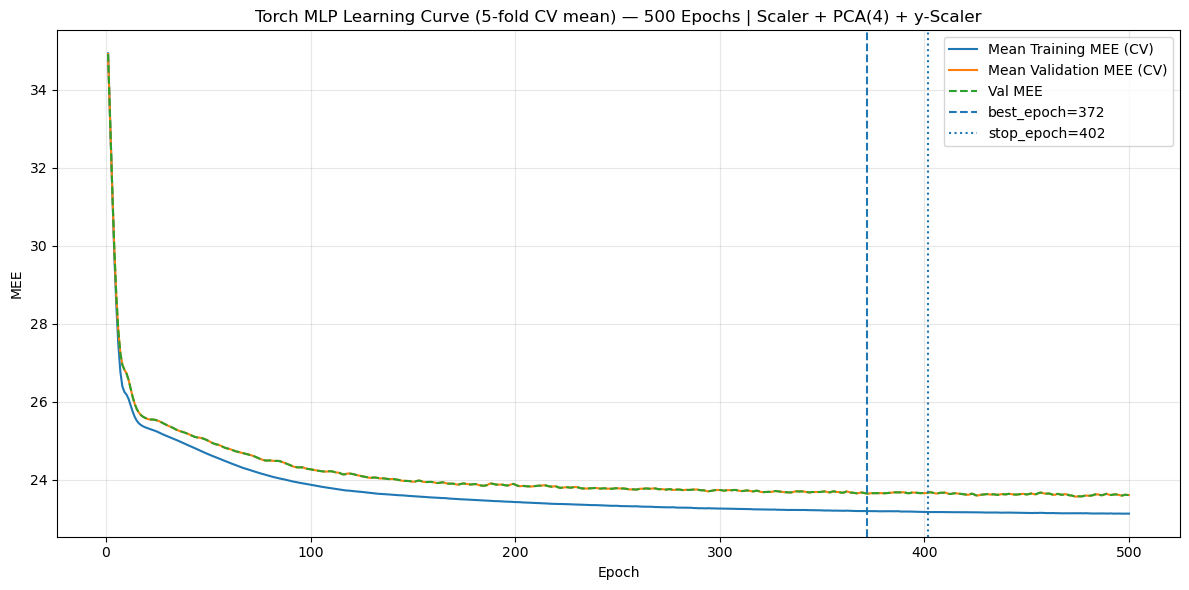

In [22]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)
MLP_BEST = gs.best_params_

train_mean, val_mean = torch_mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    best_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4,
    device=None,
    use_step_lr=False,
)

# -------------------------
# EARLY STOPPING (post-hoc) on mean val curve
# -------------------------
def early_stop_epoch(val_curve, patience=30, min_delta=1e-4, smooth_window=1):
    v = np.asarray(val_curve, dtype=float)

    # optional smoothing to make the stop decision less noisy
    if smooth_window and smooth_window > 1:
        k = np.ones(smooth_window) / smooth_window
        v_s = np.convolve(v, k, mode="same")
    else:
        v_s = v

    best_val = np.inf
    best_ep0 = 0
    wait = 0
    stop_ep0 = len(v_s) - 1

    for ep0, val in enumerate(v_s):
        if val < best_val - min_delta:
            best_val = val
            best_ep0 = ep0
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                stop_ep0 = ep0
                break

    # return 1-based epochs
    return best_ep0 + 1, stop_ep0 + 1, v[best_ep0], v_s

best_epoch, stop_epoch, best_val, val_smooth = early_stop_epoch(
    val_mean,
    patience=30,
    min_delta=1e-4,
    smooth_window=1,   # bạn có thể để 1 nếu không muốn smooth
)

print(f"Early-stop selected best_epoch = {best_epoch} | best_val_MEE = {best_val:.6f}")
print(f"Early-stop would stop at epoch = {stop_epoch} (patience reached)")

# -------------------------
# PLOT
# -------------------------
epochs = np.arange(1, len(train_mean) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")

# optional: plot smoothed val
plt.plot(epochs, val_smooth, linestyle="--", label="Val MEE")

# mark best epoch and stop epoch
plt.axvline(best_epoch, linestyle="--", label=f"best_epoch={best_epoch}")
plt.axvline(stop_epoch, linestyle=":",  label=f"stop_epoch={stop_epoch}")

plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("Torch MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

In [23]:
from sklearn.base import clone

best_epoch_to_use = best_epoch  

best_model_es = clone(gs.best_estimator_)
best_model_es.set_params(regressor__mlp__max_epochs=best_epoch_to_use)
best_model_es.fit(X_dev, y_dev)

y_int_pred = best_model_es.predict(X_int)
print("Internal 20% MEE (refit @best_epoch):", mee(y_int, y_int_pred))

Internal 20% MEE (refit @best_epoch): 23.982396152096666


In [26]:
cv5 = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_splits = list(cv5.split(X_dev))  # fixed splits

param_grid = {
    "regressor__mlp__hidden_layer_sizes": [(8, 4), (16, 16), (32,16), (32, 8)],
    "regressor__mlp__activation": ["relu"],    
    "regressor__mlp__batch_size": [128],
    "regressor__mlp__lr": [0.02, 0.01],        
    "regressor__mlp__momentum": [0.7, 0.9],
    "regressor__mlp__nesterov": [True],
    "regressor__mlp__weight_decay": [0.01],
    "regressor__mlp__max_epochs": [100],           
}

gs = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=mee_scorer,
    cv=cv_splits,
    n_jobs=1,                 # IMPORTANT for torch on GPU
    refit=True,               # refit best on full X_dev/y_dev
    return_train_score=True,
    error_score=np.nan,
    verbose=2
)

gs.fit(X_dev, y_dev)

print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=128, regressor__mlp__hidden_layer_sizes=(8, 4), regressor__mlp__lr=0.02, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.4s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=128, regressor__mlp__hidden_layer_sizes=(8, 4), regressor__mlp__lr=0.02, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.6s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=128, regressor__mlp__hidden_layer_sizes=(8, 4), regressor__mlp__lr=0.02, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.4s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=128

Early-stop selected best_epoch = 258 | best_val_MEE = 23.594238
Early-stop would stop at epoch = 288 (patience reached)


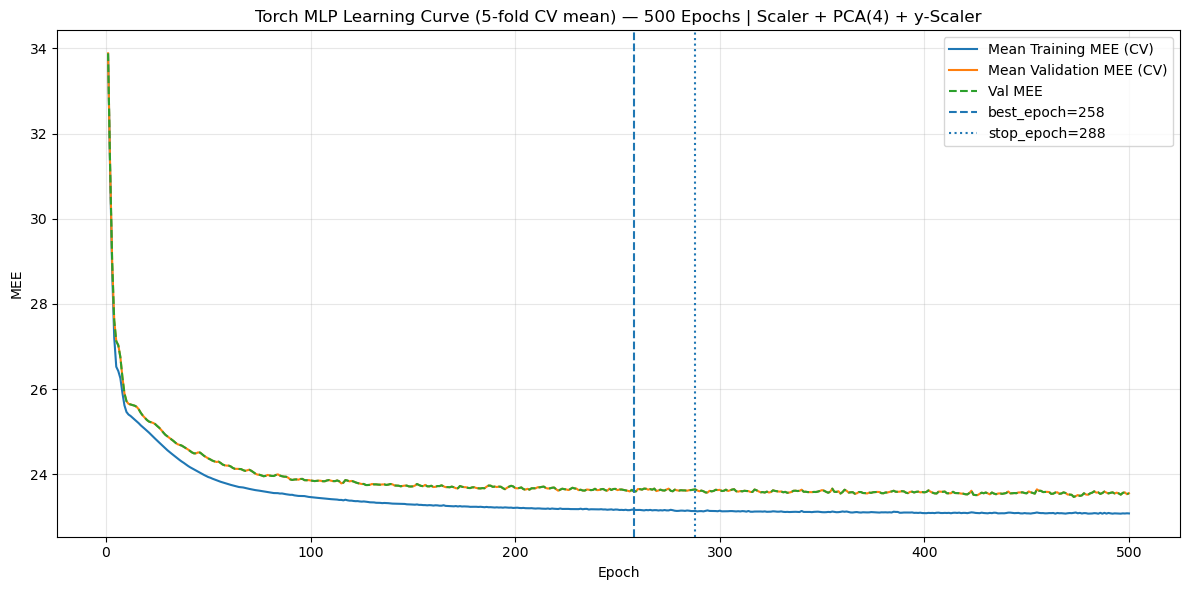

In [27]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)
MLP_BEST = gs.best_params_

train_mean, val_mean = torch_mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    best_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4,
    device=None,
    use_step_lr=False,
)

# -------------------------
# EARLY STOPPING (post-hoc) on mean val curve
# -------------------------
def early_stop_epoch(val_curve, patience=30, min_delta=1e-4, smooth_window=1):
    v = np.asarray(val_curve, dtype=float)

    # optional smoothing to make the stop decision less noisy
    if smooth_window and smooth_window > 1:
        k = np.ones(smooth_window) / smooth_window
        v_s = np.convolve(v, k, mode="same")
    else:
        v_s = v

    best_val = np.inf
    best_ep0 = 0
    wait = 0
    stop_ep0 = len(v_s) - 1

    for ep0, val in enumerate(v_s):
        if val < best_val - min_delta:
            best_val = val
            best_ep0 = ep0
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                stop_ep0 = ep0
                break

    # return 1-based epochs
    return best_ep0 + 1, stop_ep0 + 1, v[best_ep0], v_s

best_epoch, stop_epoch, best_val, val_smooth = early_stop_epoch(
    val_mean,
    patience=30,
    min_delta=1e-4,
    smooth_window=1,   # bạn có thể để 1 nếu không muốn smooth
)

print(f"Early-stop selected best_epoch = {best_epoch} | best_val_MEE = {best_val:.6f}")
print(f"Early-stop would stop at epoch = {stop_epoch} (patience reached)")

# -------------------------
# PLOT
# -------------------------
epochs = np.arange(1, len(train_mean) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")

# optional: plot smoothed val
plt.plot(epochs, val_smooth, linestyle="--", label="Val MEE")

# mark best epoch and stop epoch
plt.axvline(best_epoch, linestyle="--", label=f"best_epoch={best_epoch}")
plt.axvline(stop_epoch, linestyle=":",  label=f"stop_epoch={stop_epoch}")

plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("Torch MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

In [28]:
from sklearn.base import clone

best_epoch_to_use = best_epoch  # hoặc stop_epoch

best_model_es = clone(gs.best_estimator_)
best_model_es.set_params(regressor__mlp__max_epochs=best_epoch_to_use)
best_model_es.fit(X_dev, y_dev)

y_int_pred = best_model_es.predict(X_int)
print("Internal 20% MEE (refit @best_epoch):", mee(y_int, y_int_pred))

Internal 20% MEE (refit @best_epoch): 24.038299014310734


In [29]:
cv5 = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_splits = list(cv5.split(X_dev))  # fixed splits

param_grid = {
    "regressor__mlp__hidden_layer_sizes": [(8, 4), (16, 16), (32,16), (16, 8)],
    "regressor__mlp__activation": ["relu"],    
    "regressor__mlp__batch_size": [128],
    "regressor__mlp__lr": [0.02, 0.03],        
    "regressor__mlp__momentum": [0.7, 0.9],
    "regressor__mlp__nesterov": [True],
    "regressor__mlp__weight_decay": [0.01],
    "regressor__mlp__max_epochs": [100],           
}

gs = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=mee_scorer,
    cv=cv_splits,
    n_jobs=1,                 # IMPORTANT for torch on GPU
    refit=True,               # refit best on full X_dev/y_dev
    return_train_score=True,
    error_score=np.nan,
    verbose=2
)

gs.fit(X_dev, y_dev)

print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=128, regressor__mlp__hidden_layer_sizes=(8, 4), regressor__mlp__lr=0.02, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.6s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=128, regressor__mlp__hidden_layer_sizes=(8, 4), regressor__mlp__lr=0.02, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.6s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=128, regressor__mlp__hidden_layer_sizes=(8, 4), regressor__mlp__lr=0.02, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.5s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=128

Early-stop selected best_epoch = 244 | best_val_MEE = 23.548257
Early-stop would stop at epoch = 274 (patience reached)


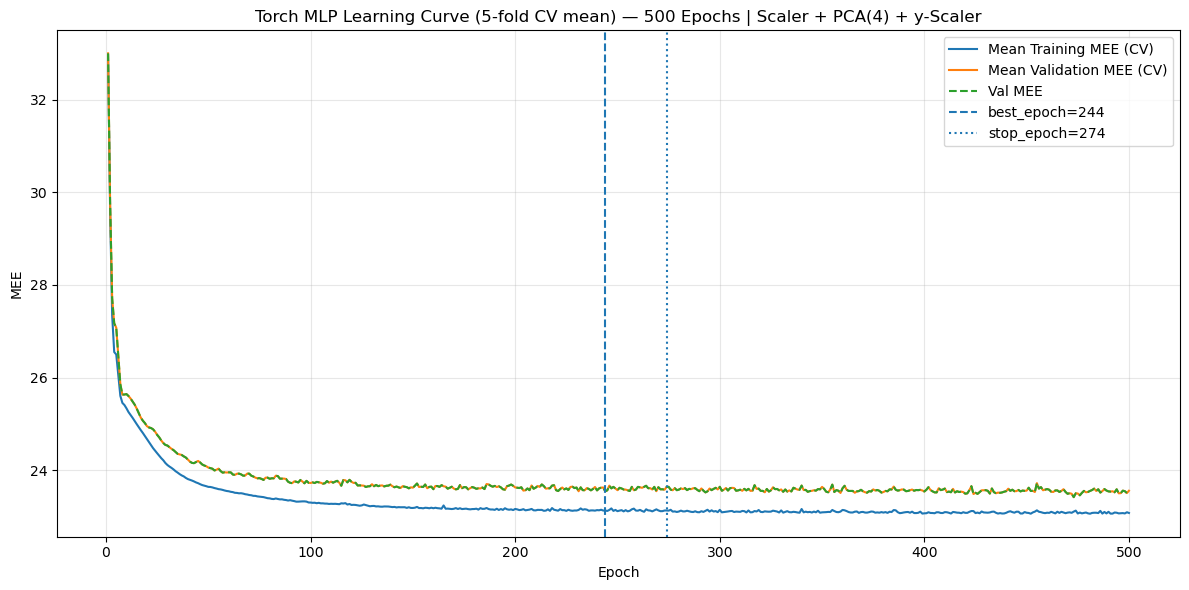

In [30]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)
MLP_BEST = gs.best_params_

train_mean, val_mean = torch_mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    best_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4,
    device=None,
    use_step_lr=False,
)

# -------------------------
# EARLY STOPPING (post-hoc) on mean val curve
# -------------------------
def early_stop_epoch(val_curve, patience=30, min_delta=1e-4, smooth_window=1):
    v = np.asarray(val_curve, dtype=float)

    # optional smoothing to make the stop decision less noisy
    if smooth_window and smooth_window > 1:
        k = np.ones(smooth_window) / smooth_window
        v_s = np.convolve(v, k, mode="same")
    else:
        v_s = v

    best_val = np.inf
    best_ep0 = 0
    wait = 0
    stop_ep0 = len(v_s) - 1

    for ep0, val in enumerate(v_s):
        if val < best_val - min_delta:
            best_val = val
            best_ep0 = ep0
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                stop_ep0 = ep0
                break

    # return 1-based epochs
    return best_ep0 + 1, stop_ep0 + 1, v[best_ep0], v_s

best_epoch, stop_epoch, best_val, val_smooth = early_stop_epoch(
    val_mean,
    patience=30,
    min_delta=1e-4,
    smooth_window=1,   # bạn có thể để 1 nếu không muốn smooth
)

print(f"Early-stop selected best_epoch = {best_epoch} | best_val_MEE = {best_val:.6f}")
print(f"Early-stop would stop at epoch = {stop_epoch} (patience reached)")

# -------------------------
# PLOT
# -------------------------
epochs = np.arange(1, len(train_mean) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")

# optional: plot smoothed val
plt.plot(epochs, val_smooth, linestyle="--", label="Val MEE")

# mark best epoch and stop epoch
plt.axvline(best_epoch, linestyle="--", label=f"best_epoch={best_epoch}")
plt.axvline(stop_epoch, linestyle=":",  label=f"stop_epoch={stop_epoch}")

plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("Torch MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

In [31]:
from sklearn.base import clone

best_epoch_to_use = best_epoch  # hoặc stop_epoch

best_model_es = clone(gs.best_estimator_)
best_model_es.set_params(regressor__mlp__max_epochs=best_epoch_to_use)
best_model_es.fit(X_dev, y_dev)

y_int_pred = best_model_es.predict(X_int)
print("Internal 20% MEE (refit @best_epoch):", mee(y_int, y_int_pred))

Internal 20% MEE (refit @best_epoch): 24.05558740930007


# phase 6: tune with best model of previous and 3 layers models, also increase learning rate

In [33]:
cv5 = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_splits = list(cv5.split(X_dev))  # fixed splits

param_grid = {
    "regressor__mlp__hidden_layer_sizes": [(16, 32, 8), (16, 16, 4), (32,16), (32, 16, 4)],
    "regressor__mlp__activation": ["relu"],    
    "regressor__mlp__batch_size": [128],
    "regressor__mlp__lr": [0.05, 0.03],        
    "regressor__mlp__momentum": [0.7, 0.9],
    "regressor__mlp__nesterov": [True],
    "regressor__mlp__weight_decay": [0.01],
    "regressor__mlp__max_epochs": [100],           
}

gs = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=mee_scorer,
    cv=cv_splits,
    n_jobs=1,                 # IMPORTANT for torch on GPU
    refit=True,               # refit best on full X_dev/y_dev
    return_train_score=True,
    error_score=np.nan,
    verbose=2
)

gs.fit(X_dev, y_dev)

print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=128, regressor__mlp__hidden_layer_sizes=(16, 32, 8), regressor__mlp__lr=0.05, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.6s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=128, regressor__mlp__hidden_layer_sizes=(16, 32, 8), regressor__mlp__lr=0.05, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.8s
[CV] END regressor__mlp__activation=relu, regressor__mlp__batch_size=128, regressor__mlp__hidden_layer_sizes=(16, 32, 8), regressor__mlp__lr=0.05, regressor__mlp__max_epochs=100, regressor__mlp__momentum=0.7, regressor__mlp__nesterov=True, regressor__mlp__weight_decay=0.01; total time=   1.7s
[CV] END regressor__mlp__activation=relu, regressor__mlp_

Early-stop selected best_epoch = 244 | best_val_MEE = 23.548257
Early-stop would stop at epoch = 274 (patience reached)


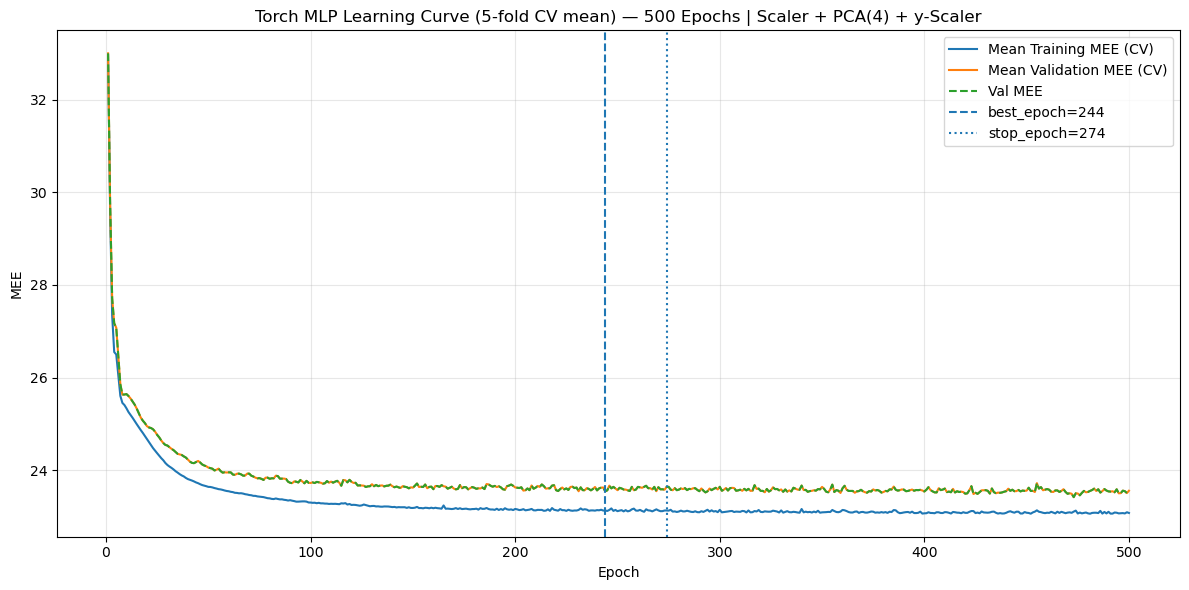

In [34]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)
MLP_BEST = gs.best_params_

train_mean, val_mean = torch_mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    best_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4,
    device=None,
    use_step_lr=False,
)

# -------------------------
# EARLY STOPPING (post-hoc) on mean val curve
# -------------------------
def early_stop_epoch(val_curve, patience=30, min_delta=1e-4, smooth_window=1):
    v = np.asarray(val_curve, dtype=float)

    # optional smoothing to make the stop decision less noisy
    if smooth_window and smooth_window > 1:
        k = np.ones(smooth_window) / smooth_window
        v_s = np.convolve(v, k, mode="same")
    else:
        v_s = v

    best_val = np.inf
    best_ep0 = 0
    wait = 0
    stop_ep0 = len(v_s) - 1

    for ep0, val in enumerate(v_s):
        if val < best_val - min_delta:
            best_val = val
            best_ep0 = ep0
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                stop_ep0 = ep0
                break

    # return 1-based epochs
    return best_ep0 + 1, stop_ep0 + 1, v[best_ep0], v_s

best_epoch, stop_epoch, best_val, val_smooth = early_stop_epoch(
    val_mean,
    patience=30,
    min_delta=1e-4,
    smooth_window=1,   
)

print(f"Early-stop selected best_epoch = {best_epoch} | best_val_MEE = {best_val:.6f}")
print(f"Early-stop would stop at epoch = {stop_epoch} (patience reached)")

# -------------------------
# PLOT
# -------------------------
epochs = np.arange(1, len(train_mean) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")

# optional: plot smoothed val
plt.plot(epochs, val_smooth, linestyle="--", label="Val MEE")

# mark best epoch and stop epoch
plt.axvline(best_epoch, linestyle="--", label=f"best_epoch={best_epoch}")
plt.axvline(stop_epoch, linestyle=":",  label=f"stop_epoch={stop_epoch}")

plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("Torch MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

In [35]:
from sklearn.base import clone

best_epoch_to_use = best_epoch  

best_model_es = clone(gs.best_estimator_)
best_model_es.set_params(regressor__mlp__max_epochs=best_epoch_to_use)
best_model_es.fit(X_dev, y_dev)

y_int_pred = best_model_es.predict(X_int)
print("Internal 20% MEE (refit @best_epoch):", mee(y_int, y_int_pred))

Internal 20% MEE (refit @best_epoch): 24.05558740930007
